# Faster R-CNN for Object Tracking

In this notebook we will leverage a pre-trained [Faster R-CNN](https://arxiv.org/abs/1506.01497) neural network in order to perform the object tracking task.
The architecture of a Faster R-CNN is characterized by the **Region Proposal Network**, where it slides a small network over the feature map extracted by the backbone in a sliding window fashion, and at each window location it generates multiple potential bounding box (named *anchors*): for each one of them, the network predicts whether the anchor contains an object or not and the coordinates for the bounding box refinement. These outputs are then taken as input to a *Region of Interest Pooling* layer, which converts each proposal into a fixed-size feature vector (this allows to handle varying-sized objects). The ROI Pooling layer's output then goes through a final fully connected layer which performs the actual detection, which is composed by two output branches: a *classification* branch and a *bounding box regressor* which further refines the coordinates.

In our case, we use a [Faster R-CNN with MobileNetV3](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn.html) as backbone, which is specifically designed for mobile applications optmizing layer configurations, block structures and with an adaptive kernel size selection. This backbone can guarantee faster inference compared to larger bakcbones like ResNet keeping a lower memory footprint and a good balance between speed and accuracy. Moreover, the pre-trained neural network include a **Feature Pyramid Network** (FPN) which is crucial for handling objects at different scales: it creates a multi-scale feature pyramid from a single scale input, creating a structure efficient for detecting small objects at higher resolutions (lower levels), and bigger objects at lower resolutions (higher levels).

## Implementation

We first download dependencies that aren't available by default in some well known environments like *Google's Colab* or *Kaggle*:

In [1]:
!pip install roboflow torchmetrics kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


Then we perform the necessary import for this project, which mainly leverages *PyTorch* framework and the *PyTorch Vision* module.

In [35]:
import numpy as np
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from roboflow import Roboflow
from tqdm import tqdm
from matplotlib import pyplot as plt
import glob as glob
import kagglehub
from base64 import b64encode
from IPython.display import HTML
import yaml
import seaborn as sns

In order to make both training and inference faster, we enable GPU acceleration if the envorinment has a `cuda` device.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print("We use the following device: ", device)

We use the following device:  cuda


### Dataset Download

In the following section, we download and create a `torch.utils.data.Dataset` for the Traffic Signs domain. This is required in order to make the training and validation phases faster and standardized for PyTorch.

Firstly we download some testing videos upon which we will perform object tracking at the end of this notebook.

In [4]:
traffic_lights_video_path = kagglehub.dataset_download('matteoiorio/traffic-lights-video')

Then we download the traffic signs dataset which contains 10.000 images with 30 different classes:
- -Road narrows on right
- 50 mph speed limit
- Attention Please-
- Beware of children
- CYCLE ROUTE AHEAD WARNING
- Dangerous Left Curve Ahead
- Dangerous Rright Curve Ahead
- End of all speed and passing limits
- Give Way
- Go Straight or Turn Right
- Go straight or turn left
- Keep-Left
- Keep-Right
- Left Zig Zag Traffic
- No Entry
- No_Over_Taking
- Overtaking by trucks is prohibited
- Pedestrian Crossing
- Round-About
- Slippery Road Ahead
- Speed Limit 20 KMPh
- Speed Limit 30 KMPh
- Stop_Sign
- Straight Ahead Only
- Traffic_signal
- Truck traffic is prohibited
- Turn left ahead
- Turn right ahead
- Uneven Road

In [5]:
rf = Roboflow(api_key="Ex8Yj8EiaKSeCDoNeUms")
project = rf.workspace("usmanchaudhry622-gmail-com").project("traffic-and-road-signs")
version = project.version(1)
traffic_signs = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Traffic-and-Road-Signs-1 in yolov11:: 100%|██████████| 20012/20012 [00:02<00:00, 9655.66it/s] 


Now we define a `TrafficDataset` object, which purpose is to convert a yolo-optimized dataset into a format suitable for our pre-trained Faster R-CNN. Due to the fact that the latter is trained on `COCO-v1` dataset, the expect format of targets must adhere the following structure:

- `boxes`
- `labels`
- `image_id`
- `area`
- `iscrowd`

even if we are interested in the first two parameters only, we compute `area` and set to a zero-tensor the value `iscrowd`.
In order to avoid exceptions during training or validation when given as input images without bounding boxes, we must explicitly return an empty structure when this case occurs. Finally, before packing the strucutre, we convert bounding boxes yolo-based coordinates (relative coordinates), into absolute coordinates of type `[xyxy]`.

In [8]:
class TrafficDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.img_dir = os.path.join(root_dir, split, 'images')
        self.label_dir = os.path.join(root_dir, split, 'labels')

        self.img_files = [d for d in os.listdir(self.img_dir) if d.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        img_w, img_h = image.size

        label_name = '.'.join(img_name.split('.')[:3]) + ".txt"
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        labels = []

        if not os.path.exists(label_path):
            raise RuntimeError(f"Label for image {img_path} ({label_path}) does not exists!")

        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                x_min = (x_center - width / 2) * img_w
                y_min = (y_center - height / 2) * img_h
                x_max = (x_center + width / 2) * img_w
                y_max = (y_center + height / 2) * img_h

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)



        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Building targets
        # FasterRCNN needs, along with boxes and labels, fields
        # image_id, area, and iscrowd.
        if len(boxes) == 0:
          target = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
            "image_id": torch.tensor([idx]),
            "area": torch.zeros((0,), dtype=torch.float32),
            "iscrowd": torch.zeros((0,), dtype=torch.int64)
          }
        else:
          target = {
              "boxes": boxes,
              "labels": labels,
              "image_id": torch.tensor([idx]),
              "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
              "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
          }

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [9]:
base_path = traffic_signs.location

train_path = "train"
valid_path = "valid"
test_path = "test"

We load from the yaml configuration file the class names and the number of classes incremented by one, which represents the *background* class for the pre-trained model.

In [11]:
with open(os.path.join(base_path, "data.yaml")) as f:
    dataset_config = yaml.safe_load(f)
    class_labels = dataset_config["names"]
    NUM_CLASSES = int(dataset_config['nc']) + 1

### Fine Tuning

In this section we will proceed to fine tune and train on our dataset the pre-trained model.

In [22]:
SEED = 1926
NUM_EPOCHS = 15
LR = 0.0005
LR_MOMENTUM = 0.9
LR_DECAY_RATE = 0.0005
LR_SCHED_STEP_SIZE = 10
LR_SCHED_GAMMA = 0.1
BATCH_SIZE = 8

torch.manual_seed(SEED)

Then we define 

In [23]:
from torchvision.transforms import v2 as T

def get_model():
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    return model

def get_transform(train):
    transforms = []
    
    if train:
        # Small random rotations (±5°) to simulate slight camera tilts
        transforms.append(T.RandomRotation(degrees=5))
        
        # Small translation shifts (±10% of image size) to improve robustness
        transforms.append(T.RandomAffine(degrees=0, translate=(0.1, 0.1)))

        # Small brightness and contrast adjustments (±20%) to handle lighting variations
        transforms.append(T.ColorJitter(brightness=0.2, contrast=0.2))

    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True))

    return T.Compose(transforms)

In [24]:
if not os.path.exists("engine.py") \
    and not os.path.exists('utils.py') \
    and not os.path.exists("coco_utils.py") \
    and not os.path.exists("coco_eval.py") \
    and not os.path.exists("transforms.py"):

    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [25]:
def get_dataloaders():
    train_dataset = TrafficDataset(
        root_dir=base_path,
        split=train_path,
        transform=get_transform(train=True)
    )

    valid_dataset = TrafficDataset(
        root_dir=base_path,
        split=valid_path,
        transform=get_transform(train=False)
    )

    test_dataset = TrafficDataset(
        root_dir=base_path,
        split=test_path,
        transform=get_transform(train=False)
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    return train_dataloader, valid_dataloader, test_dataloader

In [26]:
from engine import train_one_epoch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_d, valid_d, test_d = get_dataloaders()

model = get_model()
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=LR_MOMENTUM,
    weight_decay=LR_DECAY_RATE
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=LR_SCHED_STEP_SIZE,
    gamma=LR_SCHED_GAMMA
)
for epoch in range(NUM_EPOCHS):
    train_one_epoch(model, optimizer, train_d, device, epoch, print_freq=10)
    lr_scheduler.step()

print("Training complete!")

Epoch: [0]  [  0/887]  eta: 0:04:56  lr: 0.000001  loss: 4.5947 (4.5947)  loss_classifier: 3.6083 (3.6083)  loss_box_reg: 0.6724 (0.6724)  loss_objectness: 0.2767 (0.2767)  loss_rpn_box_reg: 0.0373 (0.0373)  time: 0.3343  data: 0.0656  max mem: 3322
Epoch: [0]  [ 10/887]  eta: 0:04:18  lr: 0.000007  loss: 4.7908 (4.7758)  loss_classifier: 3.7278 (3.7207)  loss_box_reg: 0.9159 (0.9212)  loss_objectness: 0.0815 (0.0911)  loss_rpn_box_reg: 0.0467 (0.0428)  time: 0.2951  data: 0.0646  max mem: 3562
Epoch: [0]  [ 20/887]  eta: 0:04:18  lr: 0.000012  loss: 4.6667 (4.6961)  loss_classifier: 3.6833 (3.6875)  loss_box_reg: 0.7510 (0.8671)  loss_objectness: 0.0815 (0.0969)  loss_rpn_box_reg: 0.0466 (0.0446)  time: 0.2964  data: 0.0666  max mem: 3575
Epoch: [0]  [ 30/887]  eta: 0:04:17  lr: 0.000018  loss: 4.4600 (4.6147)  loss_classifier: 3.5548 (3.6250)  loss_box_reg: 0.7509 (0.8707)  loss_objectness: 0.0366 (0.0751)  loss_rpn_box_reg: 0.0418 (0.0439)  time: 0.3029  data: 0.0686  max mem: 3589


In [29]:
torch.save(model.state_dict(), "fastrcnn_traffic_15_large.pth")

In [66]:
def load_model(weights_path: str, device):
  model = get_model()
  if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path))
    print(f"Model successfully loaded from {weights_path}")
  model.to(device)
  return model

# model = load_model("fastrcnn_traffic.pth", device)

### Evaluation

We define the following function to compute Mean Average Precision of the model on the validation set, as well as recall and its normalised confusion matrix.

In [67]:
from torchmetrics.detection import MeanAveragePrecision
from torchmetrics import ConfusionMatrix
from torchvision.ops import box_iou

def evaluate_model(model, dataloader, device, num_classes=NUM_CLASSES, iou_threshold=0.5):
    map_metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    confmat_metric = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    
    model.eval()

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating model..."):
            images = [img.to(device) for img in images]
            predictions = model(images)

            preds_for_map = []
            targets_for_map = []

            for pred, target in zip(predictions, targets):
                preds_for_map.append({
                    'boxes': pred['boxes'].cpu(),
                    'scores': pred['scores'].cpu(),
                    'labels': pred['labels'].cpu(),
                })
                targets_for_map.append({
                    'boxes': target['boxes'].cpu(),
                    'labels': target['labels'].cpu(),
                })

                pred_boxes = pred['boxes'].cpu()
                pred_labels = pred['labels'].cpu()
                target_boxes = target['boxes'].cpu()
                target_labels = target['labels'].cpu()

                if pred_boxes.numel() > 0 and target_boxes.numel() > 0:
                    ious = box_iou(pred_boxes, target_boxes)
                    max_ious, max_idxs = ious.max(dim=1)

                    # Filter out predictions with IoU lower than threshold
                    valid = max_ious > iou_threshold
                    matched_pred_labels = pred_labels[valid]
                    matched_target_labels = target_labels[max_idxs[valid]]
                    
                    if matched_pred_labels.numel() > 0:
                        confmat_metric.update(matched_pred_labels, matched_target_labels)

            map_metric.update(preds_for_map, targets_for_map)

    map_results = map_metric.compute()
    confusion_matrix = confmat_metric.compute()

    return map_results, confusion_matrix

In [68]:
def plot_normalized_confusion_matrix(confusion_matrix, class_names):
    cm = confusion_matrix.cpu().numpy().astype(float)
    
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    
    cm_normalized = cm / row_sums

    mask = np.isclose(cm_normalized, 0.0)
    cm_display = np.ma.masked_where(mask, cm_normalized)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_display, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                mask=mask, linewidths=0.5, linecolor="gray")

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Normalized Confusion Matrix (Zeros Hidden)")
    plt.show()

def print_map_data(map_res, class_names):
    print("Mean Average Precision:")
    for name, tensor in map_res.items():
        if name in ["map_per_class", "mar_100_per_class"]:
            print("mAP per class:")
            for clz, val in zip(class_names, tensor):
                print(f'\t{clz:<40} -> {val:8.4f}')
            continue
        if name == "classes":
            continue
        print(f"{name:<20}= {tensor:8.4f}")


In [61]:
map_res, confusion_matrix = evaluate_model(model, valid_d, device)

Evaluating model...: 100%|██████████| 236/236 [00:32<00:00,  7.19it/s]


In [69]:
print_map_data(map_res, class_labels)

Mean Average Precision:
map                 =   0.7274
map_50              =   0.8967
map_75              =   0.8786
map_small           =   0.0000
map_medium          =   0.0940
map_large           =   0.7458
mar_1               =   0.7692
mar_10              =   0.7739
mar_100             =   0.7751
mar_small           =   0.0000
mar_medium          =   0.4750
mar_large           =   0.7847
mAP per class:
	-Road narrows on right                   ->   0.0000
	50 mph speed limit                       ->   0.7380
	Attention Please-                        ->   0.8225
	Beware of children                       ->   0.8470
	CYCLE ROUTE AHEAD WARNING                ->   0.8083
	Dangerous Left Curve Ahead               ->   0.8114
	Dangerous Rright Curve Ahead             ->   0.7983
	End of all speed and passing limits      ->   0.8072
	Give Way                                 ->   0.7905
	Go Straight or Turn Right                ->   0.8069
	Go straight or turn left                 ->   0.

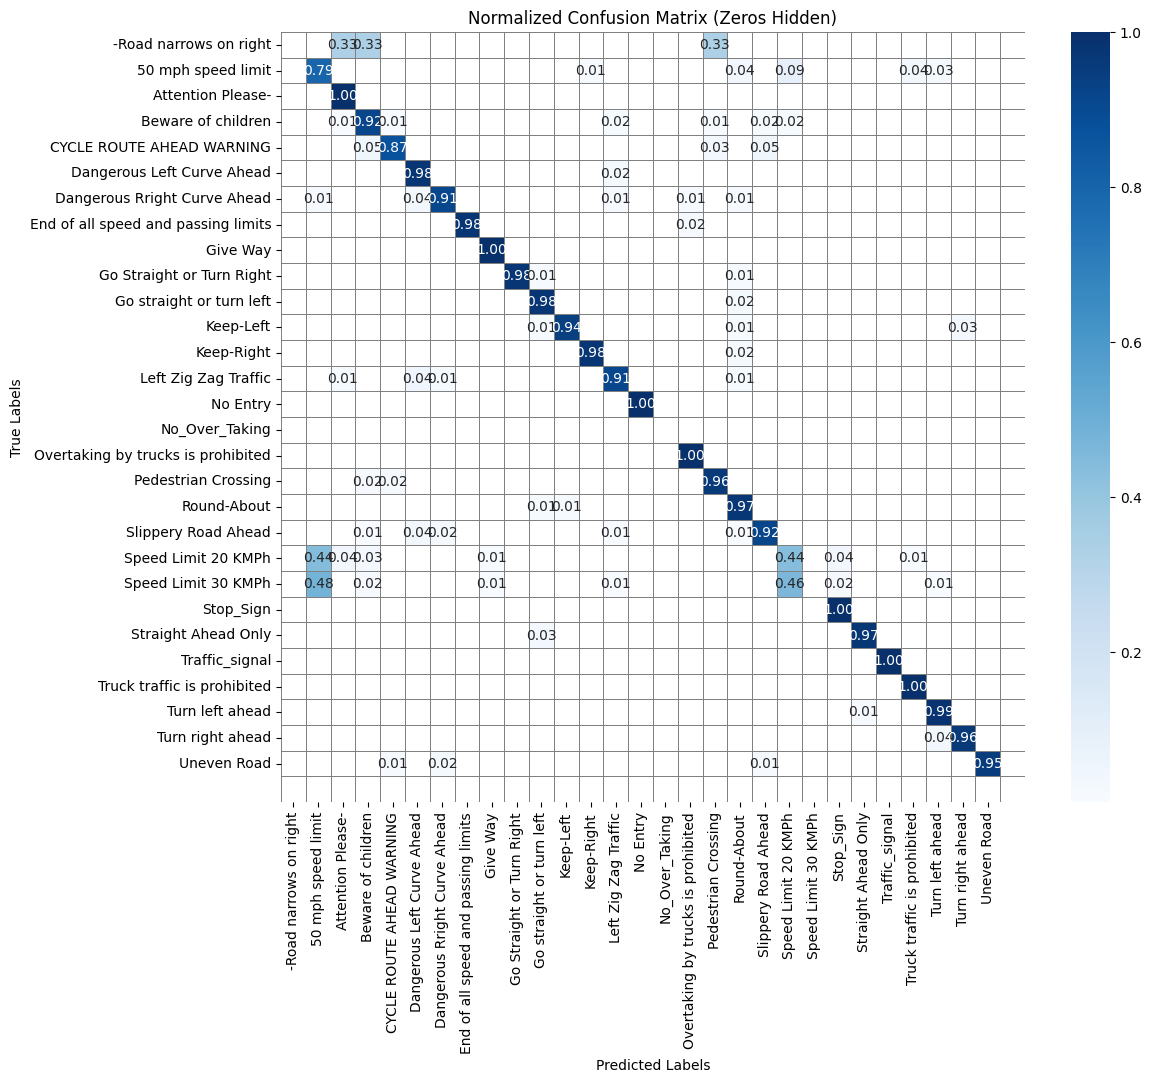

In [70]:
plot_normalized_confusion_matrix(confusion_matrix, class_labels)

In [71]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import math


def visualise_detections(model, base_path: str, images: list[str],
                         device, score_threshold=0.5, images_per_row=4,
                         figsize=(20, 1600), bbox_color="red"):

    num_images = len(images)
    num_rows = math.ceil(num_images / images_per_row)

    plt.figure()

    transform = get_transform(train=False)

    model.eval()
    with torch.no_grad():
      for idx, img_path in enumerate(images):
        image = read_image(os.path.join(base_path, img_path))
        x = transform(image)
        x = x[:3, ...].to(device)

        predictions = model([x, ])
        pred = predictions[0]

        print(pred)

        mask = pred["scores"] > score_threshold
        filtered_boxes = pred['boxes'][mask].long()
        filtered_labels = pred['labels'][mask]
        filtered_scores = pred['scores'][mask]

        label_texts = [
            f"{class_labels[label.item()]} : {score:.2f}"
            for label, score in zip(filtered_labels, filtered_scores)
        ]

        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]

        if len(filtered_boxes) > 0:
          output_image = draw_bounding_boxes(
              image,
              filtered_boxes,
              label_texts,
              colors=bbox_color,
              width=5,
              font_size=2
          )
        else:
          output_image = image

        plt.imshow(output_image.permute(1, 2, 0))
        plt.axis('off')
        plt.show()


{'boxes': tensor([[ 58.1487,  84.2566, 370.5048, 374.6491],
        [ 65.8659,  71.2385, 353.4988, 340.7148]], device='cuda:0'), 'labels': tensor([20,  1], device='cuda:0'), 'scores': tensor([0.6566, 0.5501], device='cuda:0')}


Argument 'font_size' will be ignored since 'font' is not set.


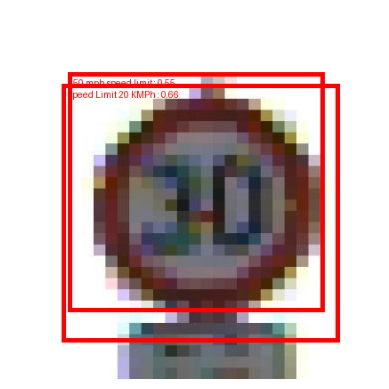

{'boxes': tensor([[ 65.0991,  76.6541, 371.7435, 372.8868],
        [ 57.7440,  57.6048, 360.1147, 345.5629]], device='cuda:0'), 'labels': tensor([20,  1], device='cuda:0'), 'scores': tensor([0.8849, 0.2082], device='cuda:0')}


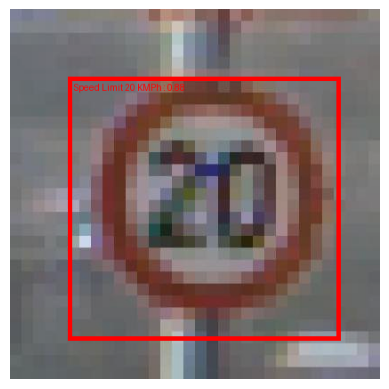

{'boxes': tensor([[ 34.0780,  33.8963, 383.7631, 379.3865],
        [ 34.5729,  25.6530, 378.0651, 382.7314],
        [ 41.9341,  38.3322, 361.7323, 369.1535]], device='cuda:0'), 'labels': tensor([20,  1, 25], device='cuda:0'), 'scores': tensor([0.8002, 0.4143, 0.0507], device='cuda:0')}


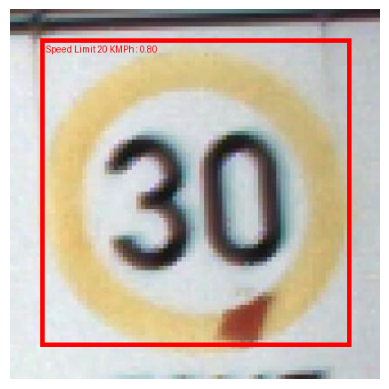

{'boxes': tensor([[ 65.4434,  73.4992, 361.0853, 340.6519],
        [ 57.4636,  85.0915, 376.2343, 357.3169]], device='cuda:0'), 'labels': tensor([ 1, 20], device='cuda:0'), 'scores': tensor([0.9332, 0.1692], device='cuda:0')}


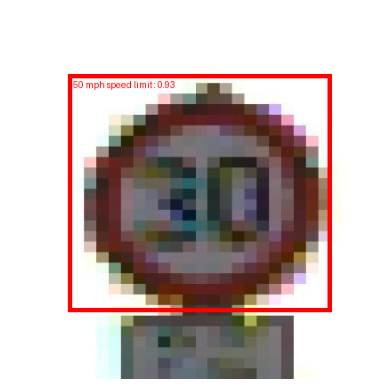

{'boxes': tensor([[ 34.4974,  56.2270, 391.0096, 380.0394],
        [ 30.7173,  47.1510, 368.8511, 369.2781]], device='cuda:0'), 'labels': tensor([20,  1], device='cuda:0'), 'scores': tensor([0.9620, 0.0521], device='cuda:0')}


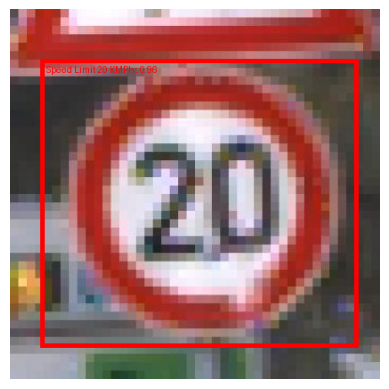

{'boxes': tensor([[ 27.3755,  34.3476, 390.8883, 389.0900],
        [ 31.3652,  51.3006, 397.0270, 400.0070]], device='cuda:0'), 'labels': tensor([ 1, 20], device='cuda:0'), 'scores': tensor([0.8656, 0.3698], device='cuda:0')}


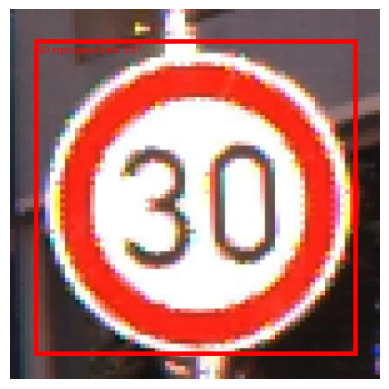

{'boxes': tensor([[ 82.3367,  92.4136, 351.6121, 337.8249]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9886], device='cuda:0')}


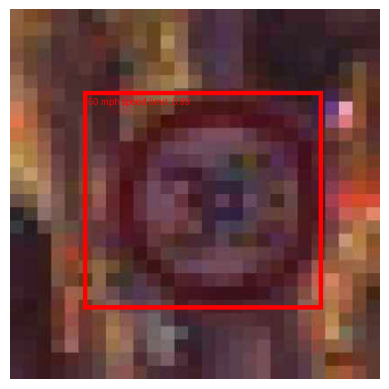

{'boxes': tensor([[ 42.3440,  21.4277, 378.6244, 371.0192],
        [ 31.9597,  34.5751, 386.3194, 374.4444]], device='cuda:0'), 'labels': tensor([ 1, 20], device='cuda:0'), 'scores': tensor([0.6978, 0.6616], device='cuda:0')}


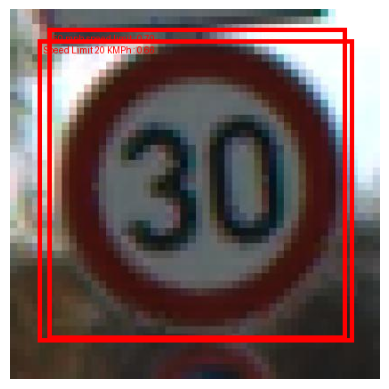

{'boxes': tensor([[ 71.2110,  68.6317, 351.8018, 342.9161]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9886], device='cuda:0')}


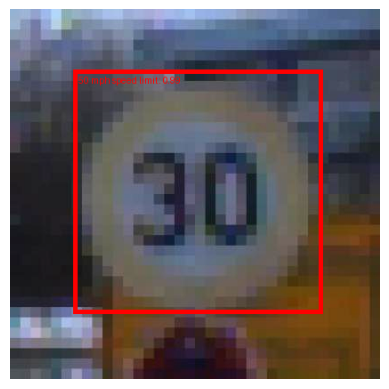

{'boxes': tensor([[ 34.0675,  39.6673, 384.0872, 390.6276],
        [ 38.9915,  29.0248, 379.2764, 373.2192]], device='cuda:0'), 'labels': tensor([20,  1], device='cuda:0'), 'scores': tensor([0.9068, 0.1551], device='cuda:0')}


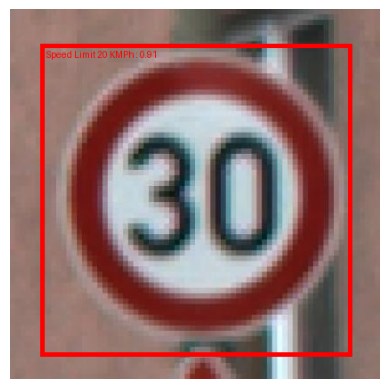

{'boxes': tensor([[ 29.4421,  38.5007, 390.6073, 389.8304],
        [ 25.9063,  27.3781, 375.6596, 391.6783]], device='cuda:0'), 'labels': tensor([20,  1], device='cuda:0'), 'scores': tensor([0.7342, 0.4188], device='cuda:0')}


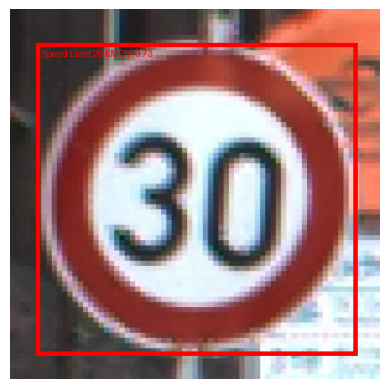

{'boxes': tensor([[ 32.6913,  25.2894, 389.6309, 389.2247],
        [ 29.1656,  35.9432, 392.5829, 386.8963]], device='cuda:0'), 'labels': tensor([ 1, 20], device='cuda:0'), 'scores': tensor([0.6516, 0.6037], device='cuda:0')}


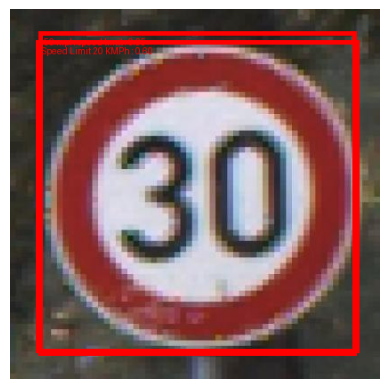

{'boxes': tensor([[ 35.7576,  41.2634, 390.4130, 360.4187],
        [ 50.7237,  44.7105, 369.8351, 366.0648]], device='cuda:0'), 'labels': tensor([20,  1], device='cuda:0'), 'scores': tensor([0.9171, 0.1634], device='cuda:0')}


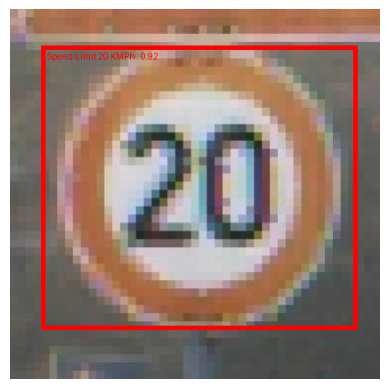

{'boxes': tensor([[ 27.2699,  26.4484, 393.3109, 386.6842],
        [ 44.1436,  49.2996, 379.7007, 377.3544]], device='cuda:0'), 'labels': tensor([16,  7], device='cuda:0'), 'scores': tensor([0.8960, 0.5058], device='cuda:0')}


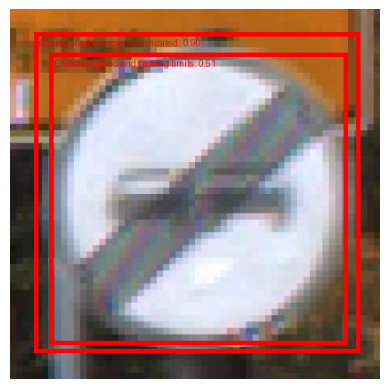

{'boxes': tensor([[ 38.3090,  52.4919, 387.6316, 382.1717],
        [ 46.3154,  41.5108, 372.9818, 369.0066]], device='cuda:0'), 'labels': tensor([20,  1], device='cuda:0'), 'scores': tensor([0.9074, 0.1766], device='cuda:0')}


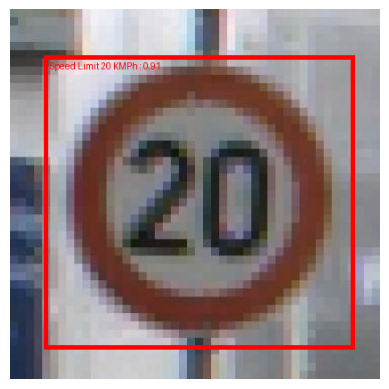

{'boxes': tensor([[ 72.5496,  75.1941, 367.6143, 349.0543],
        [ 71.0705, 100.3150, 389.1637, 364.3459]], device='cuda:0'), 'labels': tensor([ 1, 20], device='cuda:0'), 'scores': tensor([0.9496, 0.0817], device='cuda:0')}


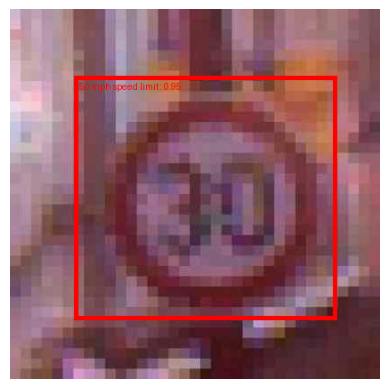

{'boxes': tensor([[ 32.2814,  29.6617, 376.9812, 388.6669],
        [ 25.9028,  48.3013, 387.8153, 395.7471]], device='cuda:0'), 'labels': tensor([ 1, 20], device='cuda:0'), 'scores': tensor([0.6535, 0.5531], device='cuda:0')}


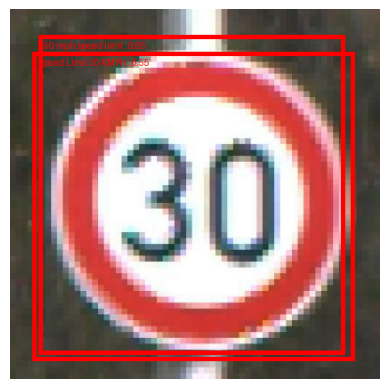

{'boxes': tensor([[ 61.4750,  71.5145, 369.1569, 357.2122],
        [ 62.9610,  94.2027, 379.8182, 377.5640]], device='cuda:0'), 'labels': tensor([ 1, 20], device='cuda:0'), 'scores': tensor([0.8901, 0.2512], device='cuda:0')}


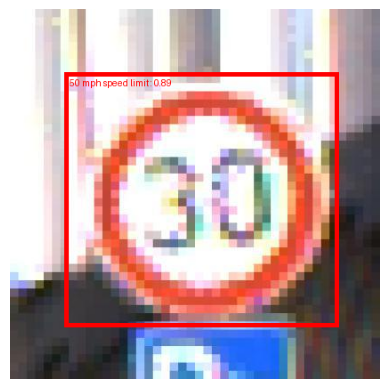

{'boxes': tensor([[ 52.3016,  74.7788, 383.9612, 390.0369],
        [ 44.1901,  52.4618, 366.4855, 368.6534]], device='cuda:0'), 'labels': tensor([20,  1], device='cuda:0'), 'scores': tensor([0.8746, 0.1835], device='cuda:0')}


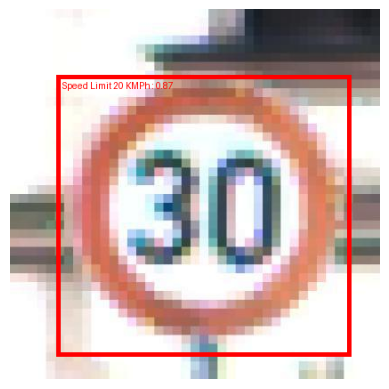

{'boxes': tensor([[ 53.8635,  55.3401, 355.4206, 347.8675],
        [ 51.3442,  71.2233, 376.1443, 362.1736]], device='cuda:0'), 'labels': tensor([ 1, 20], device='cuda:0'), 'scores': tensor([0.9615, 0.1075], device='cuda:0')}


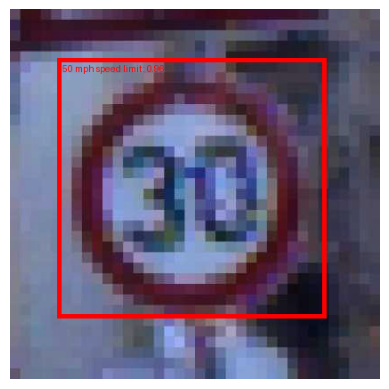

In [72]:
images = os.listdir(os.path.join(base_path, test_path, "images"))[:20]
visualise_detections(model, os.path.join(base_path, "test", "images"), images, device)

## Object Tracking

We use the already defined `compute_iou` in order to compute Intersection Over of the detected bounding boxes.

In [73]:
class FastRCNNDetector:
    def __init__(self, model, device, input_transf=None):
        self.model = model
        self.input_transf = input_transf
        self.device = device

    def detect_single_frame(self, frame, score_threshold = 0.5):
        """
        Args:
            frame: a frame loaded with opencv as a numpy array representing the read frame.
            score_threshold: float representing filtering threshold for yielded predictions.
        """
        self.model.to(self.device)
        self.model.eval()
        with torch.no_grad():
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame) # Need image as Pil Format for FastRCNN Pipeline
            if self.input_transf is not None:
                frame = self.input_transf(frame)
            frame = frame[:3, ...].to(self.device)

            predictions = model([frame, ])
            pred = predictions[0]

            mask = pred['scores'] > score_threshold
            filtered_boxes = pred['boxes'][mask].long()
            filtered_labels = pred['labels'][mask]
            
            return zip(filtered_boxes, filtered_labels)

In [74]:
def compute_iou(bb1: list, bb2: list):
  bb1_x1=bb1[0]
  bb1_y1=bb1[1]
  bb1_x2=bb1[2]
  bb1_y2=bb1[3]

  bb2_x1=bb2[0]
  bb2_y1=bb2[1]
  bb2_x2=bb2[2]
  bb2_y2=bb2[3]

  x_left = max(bb1_x1, bb2_x1)
  y_top = max(bb1_y1, bb2_y1)
  x_right = min(bb1_x2, bb2_x2)
  y_bottom = min(bb1_y2, bb2_y2)

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
  bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)

  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

In [75]:
class IOUTracker:
    def __init__(self, iou_threshold=0.5):
        self.iou_threshold = iou_threshold
        self.tracked_objects = {}
        self.next_object_id = 0

    def update(self, detections: list):
        updated_tracked_objects = {}
        assigned_detections = set()

        for obj_id, prev_bbox in self.tracked_objects.items():
            best_iou = 0
            best_det_idx = -1

            for idx, det_bbox in enumerate(detections):
                if idx in assigned_detections:
                    continue
                iou = compute_iou(prev_bbox[:4], det_bbox[:4])
                if iou > best_iou and iou >= self.iou_threshold:
                    best_iou = iou
                    best_det_idx = idx

            if best_det_idx != -1:
                updated_tracked_objects[obj_id] = detections[best_det_idx]
                assigned_detections.add(best_det_idx)

        # Add new detections as new objects
        for idx, det_bbox in enumerate(detections):
            if idx not in assigned_detections:
                updated_tracked_objects[self.next_object_id] = det_bbox
                self.next_object_id += 1

        # Update the tracked objects
        self.tracked_objects = updated_tracked_objects
        return self.tracked_objects

In [77]:
def create_new_video(video_name: str, detector, class_names=None):
    input_path = os.path.join(traffic_lights_video_path, video_name)
    output_video_path = video_name.split('.')[0] + "-output.mp4"
    cap = cv2.VideoCapture(input_path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    tracker = IOUTracker(iou_threshold=0.5)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = detector.detect_single_frame(frame)

        bbox_list = []
        for bbox, cls in results:
            bbox_list.append([bbox[0], bbox[1], bbox[2], bbox[3], cls])

        tracked_objects = tracker.update(bbox_list)

        for obj_id, bbox in tracked_objects.items():
            x1, y1, x2, y2 = map(int, bbox[:4])
            class_name = bbox[4]
            if class_names is not None:
                class_name = class_names[class_name]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'Class: {class_name}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()

    return output_video_path

In [78]:
print(os.listdir(traffic_lights_video_path))
detector = FastRCNNDetector(model, device, get_transform(train=False))
video = create_new_video("traffic_lights_1.mp4", detector, class_labels)
mp4 = open(video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(""" <video controls><source src="%s" type="video/mp4"></video>""" % data_url)

['traffic_light_3.mp4', 'yolo_best_traffic.pt', 'traffic_lights_2.mp4', 'traffic_lights_red_1.mp4', 'road_video_1.mp4', 'traffic_lights_1.mp4']


In [80]:
%pip install fvcore ptflops

Note: you may need to restart the kernel to use updated packages.


---

As a sidenote, we include some interesting characteristics of the network

In [81]:
from ptflops import get_model_complexity_info

model.eval()
macs, params = get_model_complexity_info(model, (3, 800, 800), as_strings=True, print_per_layer_stat=False)
print(f"Model insights: \n- MACs: {macs} (FLOPs: {float(macs.split(' ')[0]) * 2} billions)\n- Params: {params}")

Model insights: 
- MACs: 5.95 GMac (FLOPs: 11.9 billions)
- Params: 19.01 M


The results obtained above are now justified by the size of this Neural Network: with just 18.4 million parameters and 12.3 billions floating point operations per second (as a reference, Faster R-CNN with a ResNet-50 backbone has ~200 GFLOPs), the average precision obtained above is indeed quite good!

As a reference for such metrics, we have referred to the [EfficientDet paper](https://arxiv.org/pdf/1911.09070).

Then, it can be helpful to compute some metrics on inference time, because we recall that this model has been though for being used in edge computing scenarios.

In [82]:
import time

model.eval()
model.to(device)

input_tensor = torch.randn(1, 3, 800, 800).to(device)

def measure_inference_time(model, input_tensor, device, runs=100):
    with torch.no_grad():
        # Warm-up run
        for _ in range(5):
            _ = model(input_tensor)
        
        start_time = time.time()
        for _ in range(runs):
            _ = model(input_tensor)
        end_time = time.time()

        avg_time = (end_time - start_time) / runs
        return avg_time

model.cpu()
input_tensor_cpu = input_tensor.cpu()
cpu_time = measure_inference_time(model, input_tensor_cpu, "cpu")
print(f"Average inference time on CPU: {cpu_time:.4f} seconds")

if torch.cuda.is_available():
    model.to("cuda")
    input_tensor = input_tensor.to("cuda")
    gpu_time = measure_inference_time(model, input_tensor, "cuda")
    print(f"Average inference time on GPU: {gpu_time:.4f} seconds")
else:
    print("CUDA not available, skipping GPU measurement.")

Average inference time on CPU: 0.3426 seconds
Average inference time on GPU: 0.0146 seconds


Considering the above times, we can then determine the **maximum amount** of frames per seconds that theoretically the model can handle

In [83]:
cpu_fps = 1 / cpu_time
gpu_fps = 1 / gpu_time

# Print results
print(f"Maximum FPS on CPU: {cpu_fps:.2f} FPS")
print(f"Maximum FPS on GPU: {gpu_fps:.2f} FPS")

Maximum FPS on CPU: 2.92 FPS
Maximum FPS on GPU: 68.39 FPS
